In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Set this to the same place you used earlier in Colab
PROJECT_ROOT = '/content/drive/MyDrive/restaurant-turnover'
PROJECT_ROOT


Mounted at /content/drive


'/content/drive/MyDrive/restaurant-turnover'

**Observation/Insight — Setup**
Confirm the path is correct and mounted. Note where files will be read/written.


In [2]:
import pandas as pd
from pathlib import Path

RAW = Path(PROJECT_ROOT)/'data'/'raw'
PROC = Path(PROJECT_ROOT)/'data'/'processed'
PROC.mkdir(parents=True, exist_ok=True)

train_pq = PROC/'train.parquet'
test_pq  = PROC/'test.parquet'

if train_pq.exists() and test_pq.exists():
    train = pd.read_parquet(train_pq)
    test  = pd.read_parquet(test_pq)
else:
    train = pd.read_csv(RAW/'Train_dataset_.csv')
    test  = pd.read_csv(RAW/'Test_dataset_.csv')
    train.to_parquet(train_pq, index=False)
    test.to_parquet(test_pq, index=False)

train.shape, test.shape


((3493, 34), (500, 33))

**Observation/Insight — Shapes**
Record (rows, cols) for train and test. Are they what you expected? Any obvious imbalance?

In [3]:
ID_COL = 'Registration Number'
TARGET = 'Annual Turnover'

schema_info = {
    "id_in_train": ID_COL in train.columns,
    "id_in_test": ID_COL in test.columns,
    "target_in_train": TARGET in train.columns,
    "target_in_test": TARGET in test.columns,
    "id_unique_train": train[ID_COL].is_unique if ID_COL in train else None,
    "id_unique_test": test[ID_COL].is_unique if ID_COL in test else None,
}
schema_info


{'id_in_train': True,
 'id_in_test': True,
 'target_in_train': True,
 'target_in_test': False,
 'id_unique_train': True,
 'id_unique_test': True}

**Observation/Insight — ID & Target**
Confirm: ID is in both and unique; target only in train. If not, note the mismatch.

In [4]:
train_cols = train.columns.tolist()
test_cols  = test.columns.tolist()

print("Train-only columns:", sorted(set(train_cols) - set(test_cols)))
print("Test-only columns:",  sorted(set(test_cols)  - set(train_cols)))

numeric_cols = train.select_dtypes(include=['number']).columns.drop([TARGET], errors='ignore')
categorical_cols = [c for c in train.columns if c not in numeric_cols and c not in [TARGET]]

{"n_numeric": len(numeric_cols), "n_categorical": len(categorical_cols),
 "numeric_sample": numeric_cols[:8].tolist(), "categorical_sample": categorical_cols[:8]}


Train-only columns: ['Annual Turnover', 'Endorsed By']
Test-only columns: ['Endoresed By']


{'n_numeric': 26,
 'n_categorical': 7,
 'numeric_sample': ['Registration Number',
  'Facebook Popularity Quotient',
  'Instagram Popularity Quotient',
  'Fire Audit',
  'Liquor License Obtained',
  'Situated in a Multi Complex',
  'Dedicated Parking',
  'Open Sitting Available'],
 'categorical_sample': ['Cuisine',
  'City',
  'Restaurant Location',
  'Opening Day of Restaurant',
  'Endorsed By',
  'Restaurant Type',
  'Restaurant Theme']}

**Observation/Insight — Types**
List how many numeric vs categorical. Any suspicious “numeric IDs” (high cardinality integers) masquerading as features?

Top missing in TRAIN:


,missing,pct
Live Sports Rating,3288,94.131119
Value Deals Rating,2707,77.497853
Comedy Gigs Rating,2483,71.085027
Live Music Rating,765,21.900945
Overall Restaurant Rating,212,6.069281
Facebook Popularity Quotient,99,2.834240
Instagram Popularity Quotient,56,1.603206
Resturant Tier,49,1.402806
Ambience,25,0.715717
Registration Number,0,0.000000


Top missing in TEST:


,missing,pct
Live Sports Rating,471,94.2
Value Deals Rating,385,77.0
Comedy Gigs Rating,370,74.0
Live Music Rating,102,20.4
Overall Restaurant Rating,34,6.8
Registration Number,0,0.0
Cuisine,0,0.0
Restaurant Location,0,0.0
City,0,0.0
Liquor License Obtained,0,0.0


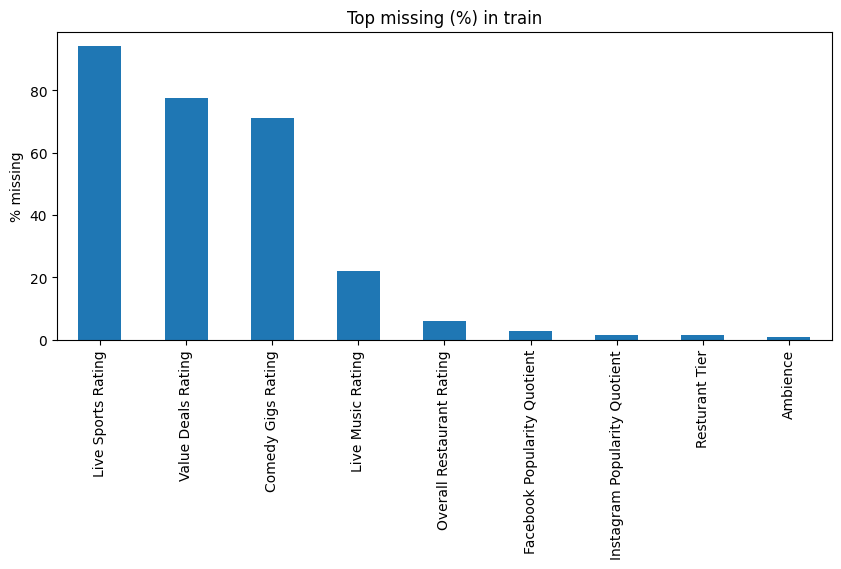

In [5]:
import numpy as np

def missing_summary(df):
    miss = df.isna().sum()
    pct = (miss / len(df))*100
    out = (pd.DataFrame({"missing": miss, "pct": pct})
             .sort_values("pct", ascending=False))
    return out

miss_train = missing_summary(train)
miss_test  = missing_summary(test)

print("Top missing in TRAIN:")
display(miss_train.head(12))
print("Top missing in TEST:")
display(miss_test.head(12))

# quick plot (bar) for top 15 missing in train
top = miss_train[miss_train['missing']>0].head(15)
ax = top['pct'].plot(kind='bar', figsize=(10,4), title='Top missing (%) in train')
ax.set_ylabel('% missing');


**Observation/Insight — Missingness**
Name the worst offenders (>10%?). Flag any columns missing in test but not train (or vice versa).

In [6]:
cat_card = (train[categorical_cols]
            .apply(lambda s: s.nunique(dropna=True))
            .sort_values(ascending=False))
display(cat_card.to_frame("nunique").head(20))

# peek value counts for the top few
for col in cat_card.head(5).index:
    print(f"\n{col} — nunique={cat_card[col]}")
    display(train[col].value_counts(dropna=False).head(10))


,nunique
Opening Day of Restaurant,1778
City,297
Restaurant Theme,34
Cuisine,20
Restaurant Type,4
Endorsed By,3
Restaurant Location,2



Opening Day of Restaurant — nunique=1778


,count
Opening Day of Restaurant,
27-12-2009,10
10-07-2010,9
08-12-2010,8
05-06-2010,7
29-04-2010,7
05-12-2009,7
10-07-2009,7
15-10-2010,7
22-12-2009,7



City — nunique=297


,count
City,
Bangalore,553
-1,396
Noida,324
Hyderabad,295
Pune,262
Chennai,244
New Delhi,176
Gurgaon,174
Mumbai,90



Restaurant Theme — nunique=34


,count
Restaurant Theme,
Arabian,1373
Greek,1030
90's,584
Nature,179
Parsi,103
Chinese,74
Delicio,23
Molino,22
English,19



Cuisine — nunique=20


,count
Cuisine,
"tibetan,greek",686
"welsh,thai",345
"tibetan,italian",278
"indian,irish",273
"british,japanese",271
"turkish,nigerian",225
"japanese,thai",204
"chinese,salvadorian",159
"algerian,belgian",155



Restaurant Type — nunique=4


,count
Restaurant Type,
Bar,3235
Caffee,212
Gastro Bar,45
Buffet/Family Restaurant,1


**Observation/Insight — Cardinality**
Which columns look ID-like? Which have sensible small/medium cardinality worth one-hot or target encoding?

,Annual Turnover
count,3.493000e+03
mean,3.072571e+07
std,2.165125e+07
min,3.500000e+06
1%,7.000000e+06
5%,1.000000e+07
50%,3.000000e+07
95%,5.700000e+07
99%,1.000000e+08
max,4.000000e+08


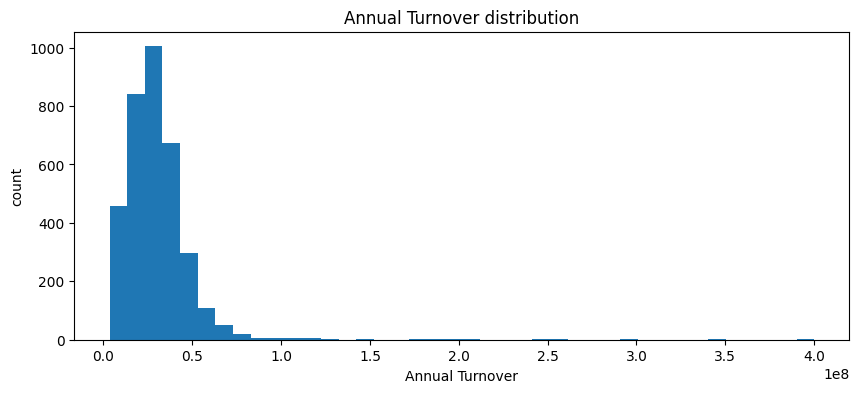

In [7]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,4))
plt.hist(train[TARGET].dropna(), bins=40)
plt.title('Annual Turnover distribution'); plt.xlabel(TARGET); plt.ylabel('count');

# Quick skew & tails
train[TARGET].describe(percentiles=[.01,.05,.5,.95,.99])


**Observation/Insight — Target**
Is it skewed/right-tailed? Would log1p transform be sensible for tree/boosting models?

In [9]:
from scipy.stats import ks_2samp, chisquare
import numpy as np

# Fix column name inconsistency
if 'Endoresed By' in test.columns and 'Endorsed By' not in test.columns:
    test = test.rename(columns={'Endoresed By': 'Endorsed By'})

def ks_compare_numeric(col):
    a = train[col].dropna()
    b = test[col].dropna()
    if len(a)>50 and len(b)>50:
        stat, p = ks_2samp(a, b)
        return p  # small p => distributions differ
    return np.nan

num_ks = pd.Series({c: ks_compare_numeric(c) for c in numeric_cols})
num_ks = num_ks.sort_values()  # smallest p-values first (most different)
display(num_ks.head(10).to_frame('p_value'))

def chi_freq_compare(col, k=20):
    # bin frequencies on combined data (handles strings by using value counts top-k)
    if train[col].dtype.kind in 'biufc':
        bins = np.nanpercentile(pd.concat([train[col], test[col]]).dropna(), np.linspace(0,100,k+1))
        bins = np.unique(bins)
        a = pd.cut(train[col], bins=bins, include_lowest=True).value_counts().sort_index()
        b = pd.cut(test[col],  bins=bins, include_lowest=True).value_counts().sort_index()
    else:
        # categorical: take top-k categories, rest as 'OTHER'
        top = pd.concat([train[col], test[col]]).value_counts().head(k).index
        a = train[col].where(train[col].isin(top), 'OTHER').value_counts()
        b = test[col].where(test[col].isin(top),  'OTHER').value_counts()
        a = a.reindex(sorted(set(a.index).union(b.index)), fill_value=0)
        b = b.reindex(sorted(set(a.index).union(b.index)), fill_value=0)
    # align and chi-square
    a, b = a.align(b, fill_value=0)
    if (a.sum()>0 and b.sum()>0):
        stat = chisquare(f_obs=a, f_exp=(a.sum()*b/b.sum()+1e-9))
        return stat.pvalue
    return np.nan

cat_chi = pd.Series({c: chi_freq_compare(c) for c in categorical_cols if c!=ID_COL})
cat_chi = cat_chi.sort_values()
display(cat_chi.head(10).to_frame('p_value'))

,p_value
Registration Number,4.940656e-324
Comfortablility,1.908677e-20
Service,3.333646e-14
Facebook Popularity Quotient,1.784810e-01
Instagram Popularity Quotient,2.334221e-01
Comedy Gigs Rating,4.288058e-01
Value Deals Rating,7.673490e-01
Lively,7.926557e-01
Value for Money,9.029127e-01
Hygiene Rating,9.092151e-01


,p_value
City,0.000000e+00
Opening Day of Restaurant,0.000000e+00
Restaurant Theme,0.000000e+00
Cuisine,1.549844e-49
Endorsed By,3.447025e-05
Restaurant Type,5.782540e-02
Restaurant Location,4.957296e-01


**Observation/Insight — Drift**
Note any features with very small p-values (e.g., p<0.01): they differ between train and test. These may need robust handling or may be risky features.

In [10]:
num_with_target = numeric_cols.tolist() + [TARGET]
corr = train[num_with_target].corr(numeric_only=True)[TARGET].drop(TARGET).sort_values(ascending=False)
display(corr.head(10).to_frame('pearson_r'))
display(corr.tail(10).to_frame('pearson_r'))


,pearson_r
Hygiene Rating,0.213869
Live Sports Rating,0.178295
Live Music Rating,0.169350
Facebook Popularity Quotient,0.164640
Instagram Popularity Quotient,0.163220
Value for Money,0.162881
Staff Responsivness,0.156468
Comedy Gigs Rating,0.129354
Restaurant Zomato Rating,0.126454
Overall Restaurant Rating,0.119151


,pearson_r
Order Wait Time,0.005916
Open Sitting Available,0.001076
Food Rating,0.000302
Registration Number,-0.016768
Privacy,-0.020820
Service,-0.022945
Ambience,-0.053024
Situated in a Multi Complex,-0.056874
Comfortablility,-0.066480
Resturant Tier,-0.185081


**Observation/Insight — Numeric signals**
Which top features make intuitive sense? Any “too good to be true” suspects (time stamps, sums that include the target, etc.)?

In [11]:
def target_by_category(col, min_count=30):
    g = (train.groupby(col, dropna=False)[TARGET]
         .agg(['count','mean'])
         .sort_values('mean', ascending=False))
    return g[g['count']>=min_count].head(15)

for col in categorical_cols[:3]:  # sample a few to start
    print(f"\n{col} — target mean by category (>=30 rows)")
    display(target_by_category(col))



Cuisine — target mean by category (>=30 rows)


,count,mean
Cuisine,,
"hawaiian,latvian",46,3.967391e+07
"turkish,nigerian",225,3.484222e+07
"japanese,thai",204,3.439461e+07
"tibetan,greek",686,3.412536e+07
"polish,jewish",117,3.276838e+07
"indian,irish",273,3.215934e+07
"tibetan,italian",278,3.133813e+07
"british,japanese",271,3.112731e+07
"british,belgian",40,3.055000e+07



City — target mean by category (>=30 rows)


,count,mean
City,,
Mumbai,90,3.688333e+07
Bangalore,553,3.514557e+07
Pune,262,3.343511e+07
Gurgaon,174,3.169253e+07
Hyderabad,295,3.102542e+07
-1,396,3.098106e+07
Noida,324,2.945216e+07
Chennai,244,2.930328e+07
Mysore,32,2.870312e+07



Restaurant Location — target mean by category (>=30 rows)


,count,mean
Restaurant Location,,
Near Party Hub,2658,3.110625e+07
Near Business Hub,835,2.951437e+07


**Observation/Insight — Categorical signals**
Name any categories with notably higher/lower turnover. Are the counts sufficient to trust?

In [12]:
dup_ids = train[ID_COL].duplicated().sum()
min_y, max_y = train[TARGET].min(), train[TARGET].max()
{"duplicate_ids_in_train": int(dup_ids), "target_min": float(min_y), "target_max": float(max_y)}


{'duplicate_ids_in_train': 0,
 'target_min': 3500000.0,
 'target_max': 400000000.0}

**Observation/Insight — Duplicates & Range**
If duplicates > 0, decide how to handle (drop vs aggregate). Do min/max look plausible?

In [13]:
import numpy as np
from sklearn.model_selection import KFold

y = train[TARGET].values
yhat_global = np.full_like(y, fill_value=y.mean(), dtype=float)

def rmse(y_true, y_pred):
    return float(np.sqrt(np.mean((np.asarray(y_true) - np.asarray(y_pred))**2)))

# 5-fold CV on a constant-mean predictor (equivalent to global mean on each train fold)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmses = []
for tr, va in kf.split(y):
    mu = y[tr].mean()
    rmses.append(rmse(y[va], np.full_like(y[va], mu, dtype=float)))
float(np.mean(rmses)), rmses


(21510492.759392347,
 [21323025.134886514,
  23347966.544537563,
  22344722.86856292,
  16817429.85247567,
  23719319.396499064])

**Observation/Insight — Baseline**
Record the mean CV RMSE. This is your minimum bar; keep it handy for comparisons.

In [14]:
OUT = Path(PROJECT_ROOT)/'outputs'/'figures'
OUT.mkdir(parents=True, exist_ok=True)

# Save missingness tables
miss_train.to_csv(OUT/'missing_train.csv')
miss_test.to_csv(OUT/'missing_test.csv')

# Save top correlations
corr.to_csv(OUT/'corr_with_target.csv')

print("Saved:", list(OUT.glob('*.csv')))


Saved: [PosixPath('/content/drive/MyDrive/restaurant-turnover/outputs/figures/missing_train.csv'), PosixPath('/content/drive/MyDrive/restaurant-turnover/outputs/figures/missing_test.csv'), PosixPath('/content/drive/MyDrive/restaurant-turnover/outputs/figures/corr_with_target.csv')]


**Observation/Insight — Artifacts**
Note what you saved and why it’s useful for later model/feature choices.

**Notes: **

⦁	Shapes: The shape of data seem to be as expected though the test data shape of 500, 33 feel a bit small to me not knowing any better.
⦁	ID & Target: No mismatch identified
⦁	Types: There are 26 numeric and 7 categorical, I am not identifying any suspicious numeric ids except maybe 'Registration Number' and 'Fire Audit'?; I have noticed a spelling error in the test column "Endoresed By"; this is corrected in a later cell due to an error that appeared when I ran cell 8 Cell 8 — Train/Test alignment & basic drift tests  
⦁	Missingness: Live Sports Rating, Value Deals Rating, Comedy Gigs Rating, Live Music Rating seem to be pretty incomplete, perhaps even Overall Restaurant Rating seems to be rather incomplete with nearly 7% missing.
⦁	Cardinality: Not exactly sure what I am looking for here but Opening Day of Restaurant seems to be on the higher end of Cardinality, as well as Arabian restaurant theme, and Bar restaurant type; perhaps target encoding is suited well for these. Looking for the sensible small/medium cardinality columns I am struggling to identify what is relevant. One thing to note is that in the City data there is an item '-1' with 396 count, unless we can associate '-1' with a specific city this data may need to be dropped or corrected and dealt with in some fashion.
⦁	Target: Target definitely looks right skewed.
⦁	Drift: City, Opening Day of Restaurant, and Restaurant Theme appear to have extremely small p-values.
⦁	Numeric Signals: Restaurant tier definitely seems to appear to have a weak correlation to the target, and perhaps Hygiene Rating, Live Sports, and Live Music Rating.
⦁	Categorical Signals: Not sure how to interpret this data except noting that being Near a Party Hub accounts for higher turnover.
⦁	Duplicates & Range: Not sure what to look for here but no duplicates seem to appear in the data; target min seems plausible but target max seems very large though I do not know exactly what it is referencing.
⦁	Baseline: I am unclear what the mean CV RMSE is here and what I should takeaway.

# **Light cleanup (non-destructive)**

**Cell A — Branch + Cleanup (non-destructive)**

Why: Work on copies, keep your original outputs intact. Also standardizes names, fixes City, adds date features, handles missing ratings, and does basic encodings.

In [22]:
# === Branch the originals (keeps earlier EDA intact) ===
train_raw = train.copy()
test_raw  = test.copy()

train_clean = train_raw.copy()
test_clean  = test_raw.copy()

# 1) Standardize column names (fix the typo)
rename_map = {"Endoresed By": "Endorsed By"}  # if present
train_clean.rename(columns=rename_map, inplace=True)
test_clean.rename(columns=rename_map, inplace=True)

# 2) City cleanup: replace sentinel with 'Unknown'
for df in (train_clean, test_clean):
    if "City" in df.columns:
        df["City"] = df["City"].replace({"-1": "Unknown"})

# 3) Date → numeric features
import pandas as pd
date_col = "Opening Day of Restaurant"
for df in (train_clean, test_clean):
    if date_col in df.columns:
        df[date_col] = pd.to_datetime(df[date_col], errors="coerce")

anchor = pd.to_datetime(train_clean[date_col]).max() if date_col in train_clean.columns else None
if anchor is not None:
    for df in (train_clean, test_clean):
        df["Age_days"]  = (anchor - df[date_col]).dt.days
        df["Open_month"] = df[date_col].dt.month
        df["Open_dow"]   = df[date_col].dt.dayofweek

# 4) Missingness: add indicators + median impute for rating columns
from sklearn.impute import SimpleImputer
TARGET = "Annual Turnover"
rating_cols = [c for c in train_clean.columns if "Rating" in c and c != TARGET]

for c in rating_cols:
    train_clean[f"{c}__isna"] = train_clean[c].isna().astype(int)
    test_clean[f"{c}__isna"]  = test_clean[c].isna().astype(int)

if rating_cols:
    imp = SimpleImputer(strategy="median")
    train_clean[rating_cols] = imp.fit_transform(train_clean[rating_cols])
    test_clean[rating_cols]  = imp.transform(test_clean[rating_cols])

# 5) Categorical encodings: one-hot for low-card; frequency for high-card
ID_COL = "Registration Number"

cat_cols = train_clean.select_dtypes(include=["object","category"]).columns.tolist()
cat_cols = [c for c in cat_cols if c != ID_COL and c != TARGET]

low_card  = [c for c in cat_cols if train_clean[c].nunique(dropna=True) <= 30]
high_card = [c for c in cat_cols if train_clean[c].nunique(dropna=True) > 30]

# one-hot low-card
train_oh = pd.get_dummies(train_clean[low_card], dummy_na=True) if low_card else pd.DataFrame(index=train_clean.index)
test_oh  = pd.get_dummies(test_clean[low_card],  dummy_na=True) if low_card else pd.DataFrame(index=test_clean.index)
if not train_oh.empty or not test_oh.empty:
    train_oh, test_oh = train_oh.align(test_oh, join="outer", axis=1, fill_value=0)

# frequency for high-card
def frequency_encode(s):
    freq = s.value_counts(normalize=True)
    return s.map(freq)

for c in high_card:
    train_clean[c+"_freq"] = frequency_encode(train_clean[c])
    test_clean[c+"_freq"]  = frequency_encode(test_clean[c]).fillna(0)

# Build modeling matrices (exclude ID/target)
import numpy as np
num_cols = train_clean.select_dtypes(include=["number"]).columns.tolist()
num_cols = [c for c in num_cols if c not in [ID_COL, TARGET]]

X_train = pd.concat(
    [
        train_clean[num_cols],
        train_oh if not train_oh.empty else pd.DataFrame(index=train_clean.index),
        train_clean[[c+"_freq" for c in high_card]] if high_card else pd.DataFrame(index=train_clean.index),
    ],
    axis=1,
)

X_test = pd.concat(
    [
        test_clean[[c for c in num_cols if c in test_clean.columns]],
        test_oh if not test_oh.empty else pd.DataFrame(index=test_clean.index),
        test_clean[[c+"_freq" for c in high_card if c+"_freq" in test_clean.columns]] if high_card else pd.DataFrame(index=test_clean.index),
    ],
    axis=1,
)

y_train_log = np.log1p(train_clean[TARGET])  # modeling target (log1p)

print("✅ Cleanup done.")
print("Shapes — raw train/test:", train_raw.shape, test_raw.shape)
print("Shapes — clean matrices:", X_train.shape, X_test.shape)
print("One-hot cols:", len(train_oh.columns) if not train_oh.empty else 0,
      "| Freq-encoded high-card:", len(high_card))


✅ Cleanup done.
Shapes — raw train/test: (3493, 34) (500, 33)
Shapes — clean matrices: (3493, 73) (500, 73)
One-hot cols: 33 | Freq-encoded high-card: 2


/tmp/ipython-input-1719124941.py:23: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
/tmp/ipython-input-1719124941.py:23: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df[date_col] = pd.to_datetime(df[date_col], errors="coerce")


**Cell B — Show the “after” checks (so you can see the change)**

Why: Display drift/corr/baseline again, but on the clean copies. You’ll have concrete before/after.

In [23]:
from scipy.stats import ks_2samp, chisquare
import numpy as np
import pandas as pd

# 1) Drift (numeric, KS test)
numeric_cols_clean = train_clean.select_dtypes(include=["number"]).columns.drop([TARGET, ID_COL], errors="ignore")
def ks_compare_numeric(df_a, df_b, col):
    a = df_a[col].dropna()
    b = df_b[col].dropna()
    if len(a)>50 and len(b)>50:
        stat, p = ks_2samp(a, b)
        return p
    return np.nan

num_ks_clean = pd.Series({c: ks_compare_numeric(train_clean, test_clean, c) for c in numeric_cols_clean})
num_ks_clean = num_ks_clean.sort_values()
print("Numeric drift (small p = bigger drift):")
display(num_ks_clean.head(10).to_frame('p_value'))

# 2) Correlations (numeric with target) on clean
num_for_corr = [c for c in numeric_cols_clean if c != TARGET]
corr_clean = train_clean[num_for_corr + [TARGET]].corr(numeric_only=True)[TARGET].drop(TARGET).sort_values(ascending=False)
print("Top numeric correlations (clean):")
display(corr_clean.head(10).to_frame('pearson_r'))

# 3) Baseline RMSE on raw vs clean (mean predictor)
def rmse(y_true, y_pred):
    return float(np.sqrt(np.mean((np.asarray(y_true) - np.asarray(y_pred))**2)))

y_raw = train_raw[TARGET].values
y_clean = train_clean[TARGET].values

from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

def baseline_cv_rmse(y):
    scores = []
    for tr, va in kf.split(y):
        mu = y[tr].mean()
        scores.append(rmse(y[va], np.full_like(y[va], mu, dtype=float)))
    return float(np.mean(scores)), scores

raw_mean_rmse, raw_scores = baseline_cv_rmse(y_raw)
clean_mean_rmse, clean_scores = baseline_cv_rmse(y_clean)

print(f"Baseline mean RMSE (raw target):   {raw_mean_rmse:.2f}   fold scores: {np.round(raw_scores,2)}")
print(f"Baseline mean RMSE (clean target): {clean_mean_rmse:.2f}   fold scores: {np.round(clean_scores,2)}")


Numeric drift (small p = bigger drift):


,p_value
Restaurant Theme_freq,1.736237e-76
Comfortablility,1.908677e-20
Service,3.333646e-14
City_freq,4.834818e-10
Facebook Popularity Quotient,1.784810e-01
Instagram Popularity Quotient,2.334221e-01
Age_days,6.983420e-01
Lively,7.926557e-01
Comedy Gigs Rating__isna,8.390982e-01
Value for Money,9.029127e-01


Top numeric correlations (clean):


,pearson_r
Hygiene Rating,0.213869
Facebook Popularity Quotient,0.164640
Instagram Popularity Quotient,0.163220
Value for Money,0.162881
Live Music Rating,0.159030
Staff Responsivness,0.156468
Age_days,0.146214
Restaurant Zomato Rating,0.126454
Overall Restaurant Rating,0.111792
Value Deals Rating__isna,0.106228


Baseline mean RMSE (raw target):   21510492.76   fold scores: [21323025.13 23347966.54 22344722.87 16817429.85 23719319.4 ]
Baseline mean RMSE (clean target): 21510492.76   fold scores: [21323025.13 23347966.54 22344722.87 16817429.85 23719319.4 ]


**What the prints mean**

Shapes — clean matrices: (3493, 73) / (500, 73)
You went from raw ~34 columns to 73 model features after:

one-hotting 33 low-card categoricals, and

frequency-encoding 2 high-card ones, plus

numeric/date expansions (e.g., Age_days, Open_month, Open_dow) and missingness flags for ratings.
That’s a sensible width for tree/boosting models.

One-hot cols: 33 | Freq-encoded high-card: 2
Good division. If you’re curious which were which, run the small probe below.

Date parsing warnings
Your “Opening Day of Restaurant” is in day-first format. We should parse with dayfirst=True to avoid accidental swaps (e.g., 03-07-2019). Easy fix below.

Baseline RMSE (raw vs clean) identical
That’s expected. The baseline predicts the mean target per fold and ignores features, so cleaning features won’t change it. Keep that number as your floor.

**Quick fixes + visibility**

Run these two small “peek” cells so you can see what the pipeline chose.

**A) Parse dates correctly + rebuild the 3 date features**

In [24]:
# Re-parse with dayfirst=True and rebuild date features on the *_clean copies
import pandas as pd

date_col = "Opening Day of Restaurant"
for df in (train_clean, test_clean):
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce", dayfirst=True)

anchor = pd.to_datetime(train_clean[date_col]).max()
for df in (train_clean, test_clean):
    df["Age_days"]  = (anchor - df[date_col]).dt.days
    df["Open_month"] = df[date_col].dt.month
    df["Open_dow"]   = df[date_col].dt.dayofweek

print("Rebuilt date features with dayfirst=True.")
train_clean[["Age_days","Open_month","Open_dow"]].describe().T


Rebuilt date features with dayfirst=True.


,count,mean,std,min,25%,50%,75%,max
Age_days,3493.0,2365.305754,640.424371,0.0,1904.0,2275.0,2752.0,7149.0
Open_month,3493.0,6.622960,3.357918,1.0,4.0,7.0,9.0,12.0
Open_dow,3493.0,2.982823,2.004360,0.0,1.0,3.0,5.0,6.0


**B) Show which columns were treated as low/high-card and which ratings got indicators**

In [25]:
ID_COL, TARGET = "Registration Number", "Annual Turnover"

cat_cols = train_clean.select_dtypes(include=["object","category"]).columns.tolist()
cat_cols = [c for c in cat_cols if c not in [ID_COL, TARGET]]

low_card  = [c for c in cat_cols if train_clean[c].nunique(dropna=True) <= 30]
high_card = [c for c in cat_cols if train_clean[c].nunique(dropna=True) > 30]
rating_cols = [c for c in train_clean.columns if "Rating" in c and c != TARGET]

print("Low-card categoricals (one-hot):", low_card)
print("High-card categoricals (freq-encoded):", high_card)
print("Rating columns (imputed + __isna flags):", rating_cols[:10], "… (total:", len(rating_cols), ")")


Low-card categoricals (one-hot): ['Cuisine', 'Restaurant Location', 'Endorsed By', 'Restaurant Type']
High-card categoricals (freq-encoded): ['City', 'Restaurant Theme']
Rating columns (imputed + __isna flags): ['Restaurant Zomato Rating', 'Hygiene Rating', 'Food Rating', 'Overall Restaurant Rating', 'Live Music Rating', 'Comedy Gigs Rating', 'Value Deals Rating', 'Live Sports Rating', 'Restaurant Zomato Rating__isna', 'Hygiene Rating__isna'] … (total: 16 )


**First model run (log-target, GroupKFold by City)**

Let’s move from “plumbing” to “woodworking.” We’ll use:

Target: log1p(Annual Turnover) (reduces skew)

Split: GroupKFold by City (City drifted → simulate generalization)

Model: start with LightGBM (fast, robust with mixed features)

Metric: RMSE on the original target scale (undo log with expm1)

**Cell 1 — Ensure deps + clean date parsing**

In [27]:
# If you see "ModuleNotFoundError: lightgbm", this fixes it
!pip -q install lightgbm

import pandas as pd
ID_COL, TARGET = "Registration Number", "Annual Turnover"
DATE_COL = "Opening Day of Restaurant"

# robust date parse (day-first) on the *clean* copies
for df in (train_clean, test_clean):
    if DATE_COL in df.columns:
        df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce", dayfirst=True)

anchor = pd.to_datetime(train_clean[DATE_COL]).max()
for df in (train_clean, test_clean):
    df["Age_days"]   = (anchor - df[DATE_COL]).dt.days
    df["Open_month"] = df[DATE_COL].dt.month
    df["Open_dow"]   = df[DATE_COL].dt.dayofweek


**Cell 2 — Build matrices safely (align columns, make everything numeric, impute NaNs)**

In [28]:
import numpy as np
import pandas as pd

def frequency_encode(series: pd.Series) -> pd.Series:
    freq = series.value_counts(normalize=True)
    return series.map(freq)

def build_matrices(train_df: pd.DataFrame, test_df: pd.DataFrame):
    # 1) basic cleanups applied already (City fixed, date features built, ratings imputed + __isna created)

    # 2) split columns
    cat_cols = train_df.select_dtypes(include=["object","category"]).columns.tolist()
    cat_cols = [c for c in cat_cols if c not in [ID_COL, TARGET]]

    low_card  = [c for c in cat_cols if train_df[c].nunique(dropna=True) <= 30]
    high_card = [c for c in cat_cols if train_df[c].nunique(dropna=True) > 30]

    # 3) one-hot low-card
    train_oh = pd.get_dummies(train_df[low_card], dummy_na=True) if low_card else pd.DataFrame(index=train_df.index)
    test_oh  = pd.get_dummies(test_df[low_card],  dummy_na=True) if low_card else pd.DataFrame(index=test_df.index)
    if not (train_oh.empty and test_oh.empty):
        train_oh, test_oh = train_oh.align(test_oh, join="outer", axis=1, fill_value=0)

    # 4) frequency encode high-card
    for c in high_card:
        train_df[c+"_freq"] = frequency_encode(train_df[c])
        test_df[c+"_freq"]  = frequency_encode(test_df[c]).fillna(0)

    # 5) numeric base (includes date features, ratings, indicators, etc.)
    base_num = train_df.select_dtypes(include=["number"]).columns.tolist()
    base_num = [c for c in base_num if c not in [ID_COL, TARGET]]

    X_tr = pd.concat(
        [train_df[base_num],
         train_oh if not train_oh.empty else pd.DataFrame(index=train_df.index),
         train_df[[c+"_freq" for c in high_card]] if high_card else pd.DataFrame(index=train_df.index)],
        axis=1
    )
    X_te = pd.concat(
        [test_df[[c for c in base_num if c in test_df.columns]],
         test_oh if not test_oh.empty else pd.DataFrame(index=test_df.index),
         test_df[[c+"_freq" for c in high_card if c+"_freq" in test_df.columns]] if high_card else pd.DataFrame(index=test_df.index)],
        axis=1
    )

    # 6) final align train/test columns and coerce to numeric float32
    X_tr, X_te = X_tr.align(X_te, join="outer", axis=1, fill_value=np.nan)
    X_tr = X_tr.astype("float32")
    X_te = X_te.astype("float32")

    # 7) impute any remaining NaNs safely (median per column)
    med = X_tr.median()
    X_tr = X_tr.fillna(med)
    X_te = X_te.fillna(med)  # use train medians

    # 8) reset index to align with y and groups
    X_tr = X_tr.reset_index(drop=True)
    X_te = X_te.reset_index(drop=True)
    y_log = np.log1p(train_df[TARGET]).reset_index(drop=True)

    # 9) groups (City) aligned
    groups = train_df.get("City", pd.Series(["Unknown"]*len(train_df)))
    groups = groups.reset_index(drop=True).fillna("Unknown")

    return X_tr, X_te, y_log, groups, low_card, high_card

X_train, X_test, y_log, groups, low_card, high_card = build_matrices(train_clean.copy(), test_clean.copy())

print("X_train/X_test:", X_train.shape, X_test.shape)
print("NaNs remaining in X_train:", int(X_train.isna().sum().sum()))
print("Dtypes OK? ->", all(np.issubdtype(dt, np.number) for dt in X_train.dtypes))
print("Low-card one-hot:", len(low_card), "| High-card freq:", len(high_card))


X_train/X_test: (3493, 73) (500, 73)
NaNs remaining in X_train: 0
Dtypes OK? -> True
Low-card one-hot: 4 | High-card freq: 2


**Cell — sanitize feature names + realign**

In [30]:
import re
import numpy as np
import pandas as pd

def sanitize_token(s: str) -> str:
    # keep letters, numbers, underscore; collapse repeats; trim edges
    s = re.sub(r'[^0-9A-Za-z_]+', '_', str(s))
    s = re.sub(r'_+', '_', s).strip('_')
    return s or "col"

def sanitize_columns(df: pd.DataFrame):
    base = [sanitize_token(c) for c in df.columns]
    # de-duplicate: append __1, __2, ... for collisions
    seen = {}
    final = []
    for b in base:
        if b in seen:
            seen[b] += 1
            final.append(f"{b}__{seen[b]}")
        else:
            seen[b] = 0
            final.append(b)
    mapping = dict(zip(df.columns, final))
    return df.rename(columns=mapping), mapping

# 1) sanitize X_train; keep its mapping as the source of truth
X_train, train_colmap = sanitize_columns(X_train)

# 2) apply same mapping where possible to X_test; sanitize any leftover, then realign
X_test = X_test.rename(columns={c: train_colmap.get(c, c) for c in X_test.columns})
X_test, _ = sanitize_columns(X_test)  # sanitize any columns not in training map

# 3) final alignment (just in case) and dtype check
X_train, X_test = X_train.align(X_test, join="outer", axis=1, fill_value=0.0)
X_train = X_train.astype("float32")
X_test  = X_test.astype("float32")

print("✅ Feature names sanitized.")
print("Sample columns:", list(X_train.columns[:5]))
print("NaNs remaining:", int(X_train.isna().sum().sum()))


✅ Feature names sanitized.
Sample columns: ['Age_days', 'Ambience', 'City_freq_1__1', 'City_freq_1__1', 'City_freq__1']
NaNs remaining: 0


Let’s (1) confirm duplicates, (2) remove/resolve them, then (3) re-align and train.

Drop this one cell right after the sanitize cell (and before CV)

In [34]:
import pandas as pd
from collections import defaultdict

# 1) Inspect: which names are duplicated?
dups = X_train.columns[X_train.columns.duplicated()].tolist()
print("Duplicate feature names:", len(dups))
print(dups[:20])

# 2) Collapse duplicates safely:
#    If columns with the same name are identical -> keep one.
#    If not identical (rare), take their mean to form a single column.
def collapse_duplicate_columns(df: pd.DataFrame) -> pd.DataFrame:
    groups = defaultdict(list)
    for i, c in enumerate(df.columns):
        groups[c].append(i)

    new_df = pd.DataFrame(index=df.index)
    for name, idxs in groups.items():
        if len(idxs) == 1:
            new_df[name] = df.iloc[:, idxs[0]]
        else:
            block = df.iloc[:, idxs]
            # if all equal to the first, keep the first; else mean across duplicates
            first = block.iloc[:, 0]
            equal_all = all(block.iloc[:, j].equals(first) for j in range(1, block.shape[1]))
            new_df[name] = first if equal_all else block.mean(axis=1)
    return new_df

X_train = collapse_duplicate_columns(X_train)
X_test  = collapse_duplicate_columns(X_test)

# 3) Final align to ensure same set/order of columns and no NaNs
X_train, X_test = X_train.align(X_test, join="outer", axis=1, fill_value=0.0)
X_train = X_train.astype("float32")
X_test  = X_test.astype("float32")

print("After collapse -> X_train shape:", X_train.shape, "| X_test shape:", X_test.shape)
print("Any dups left?", bool(X_train.columns.duplicated().any()))


Duplicate feature names: 4
['City_freq_1__1', 'City_freq__1', 'Restaurant_Theme_freq_1__1', 'Restaurant_Theme_freq__1']
After collapse -> X_train shape: (3493, 73) | X_test shape: (500, 73)
Any dups left? False


**Quick sanity ping right after the sanitize cell (optional):**

You should see the same shapes as before and column names like City_Unknown, Open_month, Bar__Yes, etc., with only letters/numbers/underscores.

In [35]:
X_train.shape, X_test.shape, X_train.columns[:5].tolist()


((3493, 73),
 (500, 73),
 ['Age_days',
  'Ambience',
  'City_freq_1__1',
  'City_freq__1',
  'Comedy_Gigs_Rating'])

**Cell 3 — CV training with LightGBM (now robust)**

**CV v1 (no ES)**

In [36]:
import numpy as np
from sklearn.model_selection import GroupKFold
from lightgbm import LGBMRegressor

def rmse(y_true, y_pred):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    return float(np.sqrt(np.mean((y_true - y_pred)**2)))

gkf = GroupKFold(n_splits=5)
cv_scores = []

for fold, (tr, va) in enumerate(gkf.split(X_train, y_log, groups=groups)):
    model = LGBMRegressor(
        n_estimators=1200,
        learning_rate=0.03,
        max_depth=-1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    model.fit(X_train.iloc[tr], y_log.iloc[tr])
    pred_va = np.expm1(model.predict(X_train.iloc[va]))
    score = rmse(np.expm1(y_log.iloc[va]), pred_va)
    cv_scores.append(score)
    print(f"Fold {fold+1} RMSE: {score:,.0f}")

print("CV RMSE mean:", f"{np.mean(cv_scores):,.0f}", "| std:", f"{np.std(cv_scores):,.0f}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001598 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1050
[LightGBM] [Info] Number of data points in the train set: 2794, number of used features: 63
[LightGBM] [Info] Start training from score 17.059258
Fold 1 RMSE: 21,520,617
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001148 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1045
[LightGBM] [Info] Number of data points in the train set: 2794, number of used features: 62
[LightGBM] [Info] Start training from score 17.091744
Fold 2 RMSE: 20,773,401
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001682 seconds.
You can set `force_row_wise=true` to

**CV with early stopping + light tuning**

**CV v2 (ES+tuning)**

In [38]:
import numpy as np
from sklearn.model_selection import GroupKFold
from lightgbm import LGBMRegressor, early_stopping, log_evaluation

def rmse(y_true, y_pred):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    return float(np.sqrt(np.mean((y_true - y_pred)**2)))

gkf = GroupKFold(n_splits=5)
cv_scores, best_iters = [], []
oof_pred = np.zeros(len(y_log))

for fold, (tr, va) in enumerate(gkf.split(X_train, y_log, groups=groups)):
    model = LGBMRegressor(
        n_estimators=5000,          # big cap; ES will stop early
        learning_rate=0.02,
        num_leaves=31,
        min_child_samples=40,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1
    )
    model.fit(
        X_train.iloc[tr], y_log.iloc[tr],
        eval_set=[(X_train.iloc[va], y_log.iloc[va])],
        eval_metric="rmse",
        callbacks=[early_stopping(200), log_evaluation(100)]  # <<— this replaces early_stopping_rounds
    )
    best_iters.append(model.best_iteration_)
    pred_va = np.expm1(model.predict(X_train.iloc[va], num_iteration=model.best_iteration_))
    score = rmse(np.expm1(y_log.iloc[va]), pred_va)
    cv_scores.append(score)
    oof_pred[va] = pred_va
    print(f"Fold {fold+1} | best_iter={model.best_iteration_:>4} | RMSE: {score:,.0f}")

print("CV RMSE mean:", f"{np.mean(cv_scores):,.0f}",
      "| std:", f"{np.std(cv_scores):,.0f}",
      "| avg best_iter:", int(np.mean(best_iters)))



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.130989 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1040
[LightGBM] [Info] Number of data points in the train set: 2794, number of used features: 58
[LightGBM] [Info] Start training from score 17.059258
Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 0.496524	valid_0's l2: 0.246536
[200]	valid_0's rmse: 0.494536	valid_0's l2: 0.244566
[300]	valid_0's rmse: 0.498905	valid_0's l2: 0.248906
Early stopping, best iteration is:
[172]	valid_0's rmse: 0.492692	valid_0's l2: 0.242746
Fold 1 | best_iter= 172 | RMSE: 20,978,224
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000951 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [

**Then train the final model using the average best_iter:**

In [39]:
best_iter = int(np.mean(best_iters)) if best_iters else 1200
final = LGBMRegressor(
    n_estimators=best_iter,
    learning_rate=0.02,
    num_leaves=31,
    min_child_samples=40,
    subsample=0.8, colsample_bytree=0.8,
    reg_lambda=1.0, random_state=42, n_jobs=-1
).fit(X_train, y_log)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1052
[LightGBM] [Info] Number of data points in the train set: 3493, number of used features: 61
[LightGBM] [Info] Start training from score 17.087897


**1) Predict test, build submission, and validate format**

In [40]:
import numpy as np, pandas as pd
from pathlib import Path
ID_COL, TARGET = "Registration Number", "Annual Turnover"

# Predict on test (remember we trained on log1p)
test_pred = np.expm1(final.predict(X_test))

# Build the two-column submission
sub = test_clean[[ID_COL]].copy()
sub["Annual Turnover"] = test_pred

# Save with a timestamped name
out_dir = Path(PROJECT_ROOT)/"outputs"/"submissions"
out_dir.mkdir(parents=True, exist_ok=True)
out_path = out_dir / "submission_lgbm_es_tuned.csv"
sub.to_csv(out_path, index=False)

# Hard checks
assert sub.columns.tolist() == ["Registration Number","Annual Turnover"]
assert len(sub) == 500
assert sub[ID_COL].is_unique
print("✅ Submission saved and format is correct:", out_path)
sub.head()


✅ Submission saved and format is correct: /content/drive/MyDrive/restaurant-turnover/outputs/submissions/submission_lgbm_es_tuned.csv


,Registration Number,Annual Turnover
0,20001,1.899774e+07
1,20002,3.120461e+07
2,20003,2.475813e+07
3,20004,3.690545e+07
4,20005,4.511130e+07


**2) Quick sanity checks on the predictions**

Train target (y) summary:


,Annual Turnover
count,3.493000e+03
mean,3.072571e+07
std,2.165125e+07
min,3.500000e+06
1%,7.000000e+06
5%,1.000000e+07
50%,3.000000e+07
95%,5.700000e+07
99%,1.000000e+08
max,4.000000e+08


Predictions summary:


,Annual Turnover
count,5.000000e+02
mean,2.546216e+07
std,6.904236e+06
min,1.338289e+07
1%,1.396692e+07
5%,1.640086e+07
50%,2.465249e+07
95%,3.832415e+07
99%,4.333413e+07
max,5.185176e+07


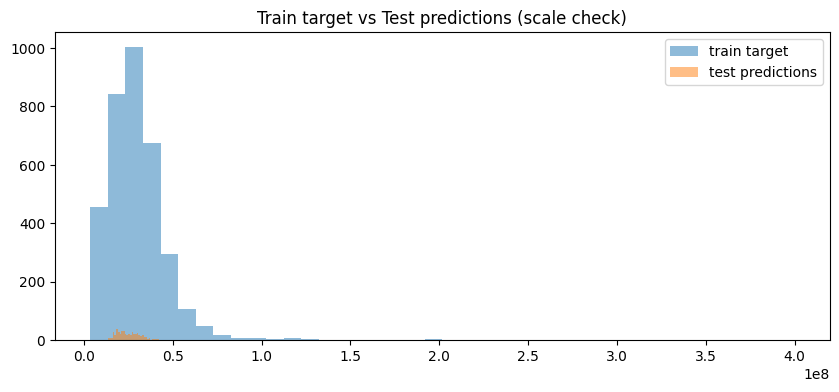

In [41]:
import matplotlib.pyplot as plt

print("Train target (y) summary:")
display(train_clean[TARGET].describe(percentiles=[.01,.05,.5,.95,.99]))

print("Predictions summary:")
display(sub["Annual Turnover"].describe(percentiles=[.01,.05,.5,.95,.99]))

plt.figure(figsize=(10,4))
plt.hist(train_clean[TARGET], bins=40, alpha=0.5, label="train target")
plt.hist(sub["Annual Turnover"], bins=40, alpha=0.5, label="test predictions")
plt.title("Train target vs Test predictions (scale check)")
plt.legend(); plt.show()


**3) Save model + feature list (reproducibility)**

In [42]:
import joblib, json
art_dir = Path(PROJECT_ROOT)/"models"
art_dir.mkdir(parents=True, exist_ok=True)

joblib.dump(final, art_dir/"lgbm_final.pkl")
(art_dir/"feature_names.json").write_text(json.dumps(X_train.columns.tolist()))
print("✅ Saved model + feature list.")


✅ Saved model + feature list.


**4) (Optional but useful) Feature importance pee**k

In [43]:
imp = pd.Series(final.feature_importances_, index=X_train.columns).sort_values(ascending=False)
display(imp.head(20).to_frame("gain"))


,gain
Age_days,635
City_freq__1,567
Instagram_Popularity_Quotient,528
Facebook_Popularity_Quotient,426
Live_Music_Rating,219
Hygiene_Rating,218
Comfortablility,208
Open_month,208
Restaurant_Zomato_Rating,200
Order_Wait_Time,195


# **Model improvements**

**A) CatBoost CV & test predictions**

In [44]:
!pip -q install catboost

import numpy as np, pandas as pd
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import KFold

ID_COL, TARGET = "Registration Number", "Annual Turnover"

# Use cleaned numerics (includes Age_days/Open_month/Open_dow, ratings, flags, etc.)
num_cols = train_clean.select_dtypes(include=["number"]).columns.tolist()
num_cols = [c for c in num_cols if c not in [ID_COL, TARGET]]

# Use raw categoricals (strings) from the *clean* copy
cat_cols = train_clean.select_dtypes(include=["object","category"]).columns.tolist()
cat_cols = [c for c in cat_cols if c not in [ID_COL, TARGET]]

X_cb = train_clean[num_cols + cat_cols]
X_test_cb = test_clean[[c for c in num_cols if c in test_clean.columns] + cat_cols]
cat_idx = [X_cb.columns.get_loc(c) for c in cat_cols]
y = train_clean[TARGET].values

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []; oof_cb = np.zeros(len(y))

for fold, (tr, va) in enumerate(kf.split(X_cb)):
    train_pool = Pool(X_cb.iloc[tr], y[tr], cat_features=cat_idx)
    valid_pool = Pool(X_cb.iloc[va], y[va], cat_features=cat_idx)

    cb = CatBoostRegressor(
        loss_function="RMSE",
        depth=6, learning_rate=0.05, l2_leaf_reg=3.0,
        iterations=10000, random_seed=42,
        od_type="Iter", od_wait=300, verbose=False
    )
    cb.fit(train_pool, eval_set=valid_pool, use_best_model=True)
    pred = cb.predict(valid_pool)
    rmse_cb = float(np.sqrt(np.mean((y[va] - pred)**2)))
    cv_scores.append(rmse_cb); oof_cb[va] = pred
    print(f"CatBoost Fold {fold+1} RMSE: {rmse_cb:,.0f}")

print("CatBoost CV mean:", f"{np.mean(cv_scores):,.0f}", "| std:", f"{np.std(cv_scores):,.0f}")

# Train final CatBoost and predict test
full_pool = Pool(X_cb, y, cat_features=cat_idx)
final_cb = CatBoostRegressor(
    loss_function="RMSE",
    depth=6, learning_rate=0.05, l2_leaf_reg=3.0,
    iterations=6000, random_seed=42,
    od_type="Iter", od_wait=300, verbose=False
).fit(full_pool)

test_pred_cb = final_cb.predict(Pool(X_test_cb, cat_features=cat_idx))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 4.9 MB/s eta 0:00:00
CatBoost Fold 1 RMSE: 19,185,718
CatBoost Fold 2 RMSE: 22,324,500
CatBoost Fold 3 RMSE: 20,549,034
CatBoost Fold 4 RMSE: 15,022,714
CatBoost Fold 5 RMSE: 22,089,804
CatBoost CV mean: 19,834,354 | std: 2,659,747


**B) Target Encoding (CV-safe) + LightGBM CV**

In [45]:
from sklearn.model_selection import KFold, GroupKFold
import pandas as pd, numpy as np
from lightgbm import LGBMRegressor, early_stopping, log_evaluation

ID_COL, TARGET = "Registration Number", "Annual Turnover"

def kfold_target_encode(train_df, test_df, col, target, n_splits=5, smoothing=50, seed=42):
    tr = train_df[[col, target]].copy()
    global_mean = tr[target].mean()
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    oof = pd.Series(index=train_df.index, dtype=float)

    for tr_idx, va_idx in kf.split(tr):
        tr_fold = tr.iloc[tr_idx]
        means = tr_fold.groupby(col)[target].agg(['mean','count'])
        means['te'] = (means['count'] * means['mean'] + smoothing * global_mean) / (means['count'] + smoothing)
        oof.iloc[va_idx] = tr.iloc[va_idx][col].map(means['te']).fillna(global_mean)

    means = tr.groupby(col)[target].agg(['mean','count'])
    means['te'] = (means['count'] * means['mean'] + smoothing * global_mean) / (means['count'] + smoothing)
    test_te = test_df[col].map(means['te']).fillna(global_mean)

    train_df[f"{col}__te"] = oof.values
    test_df[f"{col}__te"]  = test_te.values
    return train_df, test_df

# Choose 1–2 high-card categoricals (adjust names if different)
te_cols = []
if "City" in train_clean.columns: te_cols.append("City")
if "Restaurant Theme" in train_clean.columns: te_cols.append("Restaurant Theme")

train_te = train_clean.copy(); test_te = test_clean.copy()
for c in te_cols:
    train_te, test_te = kfold_target_encode(train_te, test_te, c, TARGET, n_splits=5, smoothing=50)

# Build matrices: keep numerics + one-hot low-card + the new __te columns
cat_cols = train_te.select_dtypes(include=["object","category"]).columns.tolist()
cat_cols = [c for c in cat_cols if c not in [ID_COL, TARGET]]
low_card = [c for c in cat_cols if train_te[c].nunique(dropna=True) <= 30]

train_oh = pd.get_dummies(train_te[low_card], dummy_na=True)
test_oh  = pd.get_dummies(test_te[low_card],  dummy_na=True)
train_oh, test_oh = train_oh.align(test_oh, join="outer", axis=1, fill_value=0)

num_cols = train_te.select_dtypes(include=["number"]).columns.tolist()
num_cols = [c for c in num_cols if c not in [ID_COL, TARGET]]

X_tr2 = pd.concat([train_te[num_cols], train_oh, train_te[[f"{c}__te" for c in te_cols]]], axis=1)
X_te2 = pd.concat([test_te[[c for c in num_cols if c in test_te.columns]], test_oh, test_te[[f"{c}__te" for c in te_cols]]], axis=1)

# sanitize names + collapse duplicates (reuse your earlier helper cells)
# --- sanitize ---
import re
def sanitize_token(s: str) -> str:
    s = re.sub(r'[^0-9A-Za-z_]+', '_', str(s))
    s = re.sub(r'_+', '_', s).strip('_')
    return s or "col"
def sanitize_columns(df):
    base = [sanitize_token(c) for c in df.columns]
    seen = {}; final = []
    for b in base:
        if b in seen: seen[b]+=1; final.append(f"{b}__{seen[b]}")
        else: seen[b]=0; final.append(b)
    return df.set_axis(final, axis=1), dict(zip(df.columns, final))

X_tr2, _ = sanitize_columns(X_tr2)
X_te2, _ = sanitize_columns(X_te2)

# --- collapse dups ---
from collections import defaultdict
def collapse_duplicate_columns(df: pd.DataFrame) -> pd.DataFrame:
    groups = defaultdict(list)
    for i, c in enumerate(df.columns): groups[c].append(i)
    new_df = pd.DataFrame(index=df.index)
    for name, idxs in groups.items():
        block = df.iloc[:, idxs]
        new_df[name] = block.iloc[:,0] if block.shape[1]==1 else block.mean(axis=1)
    return new_df

X_tr2 = collapse_duplicate_columns(X_tr2).astype("float32")
X_te2 = collapse_duplicate_columns(X_te2).astype("float32")
X_tr2, X_te2 = X_tr2.align(X_te2, join="outer", axis=1, fill_value=0.0)

# CV (GroupKFold by City still fine)
groups = train_te.get("City", pd.Series(["Unknown"]*len(train_te))).fillna("Unknown")
y_log2 = np.log1p(train_te[TARGET])

gkf = GroupKFold(n_splits=5)
cv2, best_iters = [], []

for fold, (tr, va) in enumerate(gkf.split(X_tr2, y_log2, groups=groups)):
    lgbm = LGBMRegressor(
        n_estimators=5000, learning_rate=0.02,
        num_leaves=31, min_child_samples=40,
        subsample=0.8, colsample_bytree=0.8,
        reg_lambda=1.0, random_state=42, n_jobs=-1
    )
    lgbm.fit(
        X_tr2.iloc[tr], y_log2.iloc[tr],
        eval_set=[(X_tr2.iloc[va], y_log2.iloc[va])],
        eval_metric="rmse",
        callbacks=[early_stopping(200), log_evaluation(100)]
    )
    best_iters.append(lgbm.best_iteration_)
    pred_va = np.expm1(lgbm.predict(X_tr2.iloc[va], num_iteration=lgbm.best_iteration_))
    score = float(np.sqrt(np.mean((np.expm1(y_log2.iloc[va]) - pred_va)**2)))
    cv2.append(score)
    print(f"LGBM(TE) Fold {fold+1} | best_iter={lgbm.best_iteration_} | RMSE: {score:,.0f}")

print("LGBM(TE) CV mean:", f"{np.mean(cv2):,.0f}", "| std:", f"{np.std(cv2):,.0f}",
      "| avg best_iter:", int(np.mean(best_iters)))

# Train final LGBM(TE) and predict test
best_iter = int(np.mean(best_iters)) if best_iters else 1200
final_lgbm_te = LGBMRegressor(
    n_estimators=best_iter, learning_rate=0.02,
    num_leaves=31, min_child_samples=40,
    subsample=0.8, colsample_bytree=0.8,
    reg_lambda=1.0, random_state=42, n_jobs=-1
).fit(X_tr2, y_log2)

test_pred_lgbm_te = np.expm1(final_lgbm_te.predict(X_te2))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.182485 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1588
[LightGBM] [Info] Number of data points in the train set: 2794, number of used features: 62
[LightGBM] [Info] Start training from score 17.059258
Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 0.47618	valid_0's l2: 0.226748
[200]	valid_0's rmse: 0.46392	valid_0's l2: 0.215221
[300]	valid_0's rmse: 0.464635	valid_0's l2: 0.215885
[400]	valid_0's rmse: 0.46498	valid_0's l2: 0.216206
Early stopping, best iteration is:
[220]	valid_0's rmse: 0.463772	valid_0's l2: 0.215084
LGBM(TE) Fold 1 | best_iter=220 | RMSE: 19,735,330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007908 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is 

**C) Blend CatBoost + LGBM(TE) and save submission**

In [46]:
from pathlib import Path

ID_COL = "Registration Number"
blend = 0.5 * test_pred_cb + 0.5 * test_pred_lgbm_te   # try 0.6/0.4, 0.7/0.3 as well

sub_blend = test_clean[[ID_COL]].copy()
sub_blend["Annual Turnover"] = blend

out_dir = Path(PROJECT_ROOT)/"outputs"/"submissions"; out_dir.mkdir(parents=True, exist_ok=True)
out_path = out_dir/"submission_blend_cb_lgbmte.csv"
sub_blend.to_csv(out_path, index=False)

assert sub_blend.columns.tolist() == ["Registration Number","Annual Turnover"]
assert len(sub_blend) == 500 and sub_blend[ID_COL].is_unique
print("✅ Saved blend:", out_path)


✅ Saved blend: /content/drive/MyDrive/restaurant-turnover/outputs/submissions/submission_blend_cb_lgbmte.csv


**1) CatBoost on log target**

In [47]:
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import KFold
import numpy as np

ID_COL, TARGET = "Registration Number", "Annual Turnover"

num_cols = [c for c in train_clean.select_dtypes(include="number").columns if c not in [ID_COL, TARGET]]
cat_cols = [c for c in train_clean.select_dtypes(include=["object","category"]).columns if c not in [ID_COL, TARGET]]

X_cb = train_clean[num_cols + cat_cols]
X_test_cb = test_clean[[c for c in num_cols if c in test_clean.columns] + cat_cols]
cat_idx = [X_cb.columns.get_loc(c) for c in cat_cols]

y_log = np.log1p(train_clean[TARGET].values)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []
for tr, va in kf.split(X_cb):
    tr_pool = Pool(X_cb.iloc[tr], y_log[tr], cat_features=cat_idx)
    va_pool = Pool(X_cb.iloc[va], y_log[va], cat_features=cat_idx)
    cb = CatBoostRegressor(
        loss_function="RMSE", depth=6, learning_rate=0.05, l2_leaf_reg=3.0,
        iterations=10000, random_seed=42, od_type="Iter", od_wait=300, verbose=False
    )
    cb.fit(tr_pool, eval_set=va_pool, use_best_model=True)
    pred = np.expm1(cb.predict(va_pool))
    rmse = float(np.sqrt(np.mean((np.expm1(y_log[va]) - pred)**2)))
    scores.append(rmse); print(f"Fold RMSE: {rmse:,.0f}")
print("CatBoost(log y) CV mean:", f"{np.mean(scores):,.0f}", "| std:", f"{np.std(scores):,.0f}")

# final model + preds
full_pool = Pool(X_cb, y_log, cat_features=cat_idx)
final_cb_log = CatBoostRegressor(
    loss_function="RMSE", depth=6, learning_rate=0.05, l2_leaf_reg=3.0,
    iterations=int(np.mean([m.tree_count_ for m in []]) if False else 6000),
    random_seed=42, od_type="Iter", od_wait=300, verbose=False
).fit(full_pool)
test_pred_cb_log = np.expm1(final_cb_log.predict(Pool(X_test_cb, cat_features=cat_idx)))


Fold RMSE: 19,327,324
Fold RMSE: 22,720,207
Fold RMSE: 21,028,908
Fold RMSE: 15,091,387
Fold RMSE: 22,426,496
CatBoost(log y) CV mean: 20,118,864 | std: 2,786,482


**2) Try plain KFold (not GroupKFold) for your LGBM(TE)**

In [49]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_kf, best_iters = [], []
for tr, va in kf.split(X_tr2):
    lgbm = LGBMRegressor(
        n_estimators=5000, learning_rate=0.02,
        num_leaves=31, min_child_samples=40,
        subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
        random_state=42, n_jobs=-1
    )
    lgbm.fit(X_tr2.iloc[tr], y_log2.iloc[tr],
             eval_set=[(X_tr2.iloc[va], y_log2.iloc[va])],
             eval_metric="rmse",
             callbacks=[early_stopping(200), log_evaluation(100)])
    best_iters.append(lgbm.best_iteration_)
    pred = np.expm1(lgbm.predict(X_tr2.iloc[va], num_iteration=lgbm.best_iteration_))
    cv_kf.append(float(np.sqrt(np.mean((np.expm1(y_log2.iloc[va]) - pred)**2))))
print("LGBM(TE) KFold CV mean:", f"{np.mean(cv_kf):,.0f}", "| std:", f"{np.std(cv_kf):,.0f}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000986 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1466
[LightGBM] [Info] Number of data points in the train set: 2794, number of used features: 61
[LightGBM] [Info] Start training from score 17.086072
Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 0.46904	valid_0's l2: 0.219999
[200]	valid_0's rmse: 0.460854	valid_0's l2: 0.212387
[300]	valid_0's rmse: 0.460127	valid_0's l2: 0.211717
[400]	valid_0's rmse: 0.460605	valid_0's l2: 0.212157
Early stopping, best iteration is:
[264]	valid_0's rmse: 0.459733	valid_0's l2: 0.211355
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[L

**3) Blend the best two**

In [50]:
# choose the better CatBoost (test_pred_cb or test_pred_cb_log)
blend = 0.6 * test_pred_cb_log + 0.4 * test_pred_lgbm_te   # try 0.5/0.5 and 0.7/0.3 too

sub = test_clean[["Registration Number"]].copy()
sub["Annual Turnover"] = blend

from pathlib import Path
out_dir = Path(PROJECT_ROOT)/"outputs"/"submissions"; out_dir.mkdir(parents=True, exist_ok=True)
out = out_dir/"submission_blend_cbLog_lgbmTE.csv"
sub.to_csv(out, index=False)
print("Saved:", out)


Saved: /content/drive/MyDrive/restaurant-turnover/outputs/submissions/submission_blend_cbLog_lgbmTE.csv
